In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics 
import warnings
import cufflinks as cf
import plotly.offline
cf.go_offline()

warnings.simplefilter("ignore")

%matplotlib inline
TEST_SIZE = 0.0

df = pd.DataFrame(pd.read_csv('train.csv').set_index('PassengerId'))

labels = df['Survived']

# keep track of the length of the original train df
TRAIN_NUM = len(df)

print(TRAIN_NUM)

# concatenate
if TEST_SIZE == 0:
    test_df = pd.DataFrame(pd.read_csv('test.csv').set_index('PassengerId'))
    df = pd.concat([df, test_df])
    
display(df)

891


,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450
...,...,...,...,...,...,...,...,...,...,...,...
1305,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,3,male,0,NaN,A.5. 3236
1306,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1,female,0,NaN,PC 17758
1307,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,3,male,0,NaN,SOTON/O.Q. 3101262


### Summary Function for Initial DataFrame

In [2]:
def summary(df):
    ret = {}
    ret['null'] = df.isnull().sum()
    ret['null_avg'] = df.isnull().mean()
    ret['dtypes'] = df.dtypes
    ret['count'] = df.count()
    ret['mean'] = df.mean()
    ret['median'] = df.median()
    ret['min'] = df.min()
    ret['max'] = df.max()
    return pd.DataFrame(ret)

display(summary(df))
print(df.dtypes.value_counts())

,null,null_avg,dtypes,count,mean,median,min,max
Age,263,0.200917,float64,1046,29.881138,28.0000,0.17,80
Cabin,1014,0.774637,object,295,NaN,NaN,NaN,NaN
Embarked,2,0.001528,object,1307,NaN,NaN,NaN,NaN
Fare,1,0.000764,float64,1308,33.295479,14.4542,0,512.329
Name,0,0.000000,object,1309,NaN,NaN,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon"
Parch,0,0.000000,int64,1309,0.385027,0.0000,0,9
Pclass,0,0.000000,int64,1309,2.294882,3.0000,1,3
Sex,0,0.000000,object,1309,NaN,NaN,female,male
SibSp,0,0.000000,int64,1309,0.498854,0.0000,0,8
Survived,418,0.319328,float64,891,0.383838,0.0000,0,1


object     5
float64    3
int64      3
dtype: int64


### Imputation for categories with only few null values
We perform mode imputation and mean imputation with the 2 missing embarked and 1 missing fare points respectively

In [3]:
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode())
df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

### Prerocess Name

In [4]:
df['married'] = 0
df['avg_name_length'] = 0

def preprocess_name(row):
    row['married'] = 1 if 'Mrs' in str(row['Name']) else 0
    row['avg_name_length'] = len(row['Name'])/len(row['Name'].split())
    return row

df = df.apply(preprocess_name, axis=1)


### Turn pclass and embarked Class into 3 Dummy Variables and Drop nan's

In [5]:
# df = df[df['Pclass'].notna()][df['Embarked'].notna()]
dummies_embarked = pd.get_dummies(df['Embarked'], prefix='embark')
dummies_pclass = pd.get_dummies(df['Pclass'], prefix='pclass')
df = pd.concat([df, dummies_embarked, dummies_pclass], axis = 1).drop(columns=['Pclass', 'Embarked'])


### Preprocess Cabin Info

In [6]:
df['top_levels'] = 0
df['bottom_levels'] = 0
df['nan_level'] = 0
def preprocess_cabin(row):
    top = ['A', 'B', 'C']
    bottom = ['D', 'E', 'F']
    cabin = str(row['Cabin'])[0] if str(row['Cabin']) != 'nan' else 'N'
    if cabin in top:
        row['top_levels'] = 1
    elif cabin in bottom:
        row['bottom_levels'] = 1
    elif cabin == 'N':
        row['nan_level'] = 1
    return row

df = df.apply(preprocess_cabin, axis=1)
dummies_cabin = pd.get_dummies(df['Cabin'], prefix='cabin_level')
df = df.drop(columns=['Cabin'])

## Imputation for Age : because it is a small dataset, we can try both mean imputation and KNN
Before checking mean imputation, let's view the age distribution in a histogram and qq plot to verify normality|

,null,null_avg,dtypes,count,mean,median,min,max
Age,263,0.200917,float64,1046,29.881138,28.0000,0.17,80
Fare,0,0.000000,float64,1309,33.295479,14.4542,0,512.329
Name,0,0.000000,object,1309,NaN,NaN,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon"
Parch,0,0.000000,int64,1309,0.385027,0.0000,0,9
Sex,0,0.000000,object,1309,NaN,NaN,female,male
SibSp,0,0.000000,int64,1309,0.498854,0.0000,0,8
Survived,418,0.319328,float64,891,0.383838,0.0000,0,1
Ticket,0,0.000000,object,1309,NaN,NaN,110152,WE/P 5735
avg_name_length,0,0.000000,float64,1309,6.578033,6.5000,4,11
bottom_levels,0,0.000000,int64,1309,0.082506,0.0000,0,1


,null,null_avg,dtypes,count,mean,median,min,max
Age,0,0.000000,float64,1309,29.709963,28.0000,0.17,80
Fare,0,0.000000,float64,1309,33.295479,14.4542,0,512.329
Name,0,0.000000,object,1309,NaN,NaN,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon"
Parch,0,0.000000,int64,1309,0.385027,0.0000,0,9
Sex,0,0.000000,object,1309,NaN,NaN,female,male
SibSp,0,0.000000,int64,1309,0.498854,0.0000,0,8
Survived,418,0.319328,float64,891,0.383838,0.0000,0,1
Ticket,0,0.000000,object,1309,NaN,NaN,110152,WE/P 5735
avg_name_length,0,0.000000,float64,1309,6.578033,6.5000,4,11
bottom_levels,0,0.000000,int64,1309,0.082506,0.0000,0,1


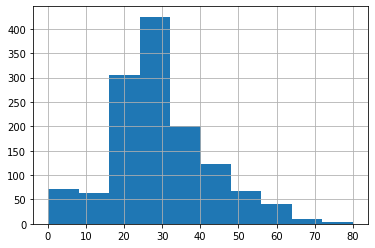

In [7]:
from statsmodels.graphics.gofplots import qqplot

def normalize_age(row):
    if str(row['Age']) == 'nan':
        row['Age'] = df['Age'].mean()
        
    return row

imputation = 'KNN'

df['Age'] = df['Age'].fillna(float('nan'))
    
if imputation == 'Norm':

    df[df['Age'].notna()]['Age'].hist()
    # we can see it is kind of a right-skewed normal distribution
    qqplot(df[df['Age'].notna()]['Age'], line='s')

    df = df.apply(normalize_age, axis = 1)
    
elif imputation == 'KNN':

    display(summary(df))
    from sklearn.impute import KNNImputer
    # train_features.fillna(float('nan'))
    imputer = KNNImputer(missing_values=float('nan'), n_neighbors=20)
    df['Age'] = imputer.fit_transform(df.drop(columns=['Survived', 'Name', 'Ticket', 'Sex'])
                                  , y=df['Age'])
display(summary(df))

df[df['Age'].notna()]['Age'].hist()

### Preprocess sex

In [8]:
def preprocess_sex(row):
    if row['Age'] < 18:
        row['Sex'] = 'Youth'
#     else:
#         row['Sex'] = 1 if (row['Sex'] == 'female') else 0
    return row
    
df = df.apply(preprocess_sex, axis = 1)
dummies_sex = pd.get_dummies(df['Sex'], prefix='sex')
df = pd.concat([df, dummies_sex], axis = 1).drop(columns=['Sex'])

## Final Cell of Analysis

In [9]:
display(df.iloc[:TRAIN_NUM])
df.iloc[:TRAIN_NUM].corr().iplot(kind='heatmap',colorscale="RdBu", title="Married/Survived Correlation Matrix")
print(summary(df))

,Age,Fare,Name,Parch,SibSp,Survived,Ticket,married,avg_name_length,embark_C,...,embark_S,pclass_1,pclass_2,pclass_3,top_levels,bottom_levels,nan_level,sex_Youth,sex_female,sex_male
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,22.0000,7.2500,"Braund, Mr. Owen Harris",0,1,0.0,A/5 21171,0,5.750000,0,...,1,0,0,1,0,0,1,0,0,1
2,38.0000,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,1.0,PC 17599,1,7.285714,1,...,0,1,0,0,1,0,0,0,1,0
3,26.0000,7.9250,"Heikkinen, Miss. Laina",0,0,1.0,STON/O2. 3101282,0,7.333333,0,...,1,0,0,1,0,0,1,0,1,0
4,35.0000,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,1.0,113803,1,6.285714,0,...,1,1,0,0,1,0,0,0,1,0
5,35.0000,8.0500,"Allen, Mr. William Henry",0,0,0.0,373450,0,6.000000,0,...,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,27.0000,13.0000,"Montvila, Rev. Juozas",0,0,0.0,211536,0,7.000000,0,...,1,0,1,0,0,0,1,0,0,1
888,19.0000,30.0000,"Graham, Miss. Margaret Edith",0,0,1.0,112053,0,7.000000,0,...,1,1,0,0,1,0,0,0,1,0
889,20.9085,23.4500,"Johnston, Miss. Catherine Helen ""Carrie""",2,1,0.0,W./C. 6607,0,8.000000,0,...,1,0,0,1,0,0,1,0,1,0


                 null  null_avg   dtypes  count       mean   median  \
Age                 0  0.000000  float64   1309  29.709963  28.0000   
Fare                0  0.000000  float64   1309  33.295479  14.4542   
Name                0  0.000000   object   1309        NaN      NaN   
Parch               0  0.000000    int64   1309   0.385027   0.0000   
SibSp               0  0.000000    int64   1309   0.498854   0.0000   
Survived          418  0.319328  float64    891   0.383838   0.0000   
Ticket              0  0.000000   object   1309        NaN      NaN   
avg_name_length     0  0.000000  float64   1309   6.578033   6.5000   
bottom_levels       0  0.000000    int64   1309   0.082506   0.0000   
embark_C            0  0.000000    int64   1309   0.206264   0.0000   
embark_Q            0  0.000000    int64   1309   0.093965   0.0000   
embark_S            0  0.000000    int64   1309   0.698243   1.0000   
married             0  0.000000    int64   1309   0.153552   0.0000   
nan_le

# Model Starts Here

### Split into Train/Val (if val necessary)

In [10]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import time

features = df.drop(columns=['Survived', 'Name', 'Ticket', 'Age'])
labels = df['Survived']

if TEST_SIZE:
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels,
                                                                            test_size=TESTSIZE)

else:
    train_features, test_features, train_labels = features.iloc[:TRAIN_NUM], features.iloc[TRAIN_NUM:], labels.iloc[:TRAIN_NUM]
    
display('Train Features', train_features)
display('Test Features', test_features)

'Train Features'

,Fare,Parch,SibSp,married,avg_name_length,embark_C,embark_Q,embark_S,pclass_1,pclass_2,pclass_3,top_levels,bottom_levels,nan_level,sex_Youth,sex_female,sex_male
PassengerId,,,,,,,,,,,,,,,,,
1,7.2500,0,1,0,5.750000,0,0,1,0,0,1,0,0,1,0,0,1
2,71.2833,0,1,1,7.285714,1,0,0,1,0,0,1,0,0,0,1,0
3,7.9250,0,0,0,7.333333,0,0,1,0,0,1,0,0,1,0,1,0
4,53.1000,0,1,1,6.285714,0,0,1,1,0,0,1,0,0,0,1,0
5,8.0500,0,0,0,6.000000,0,0,1,0,0,1,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,13.0000,0,0,0,7.000000,0,0,1,0,1,0,0,0,1,0,0,1
888,30.0000,0,0,0,7.000000,0,0,1,1,0,0,1,0,0,0,1,0
889,23.4500,2,1,0,8.000000,0,0,1,0,0,1,0,0,1,0,1,0


'Test Features'

,Fare,Parch,SibSp,married,avg_name_length,embark_C,embark_Q,embark_S,pclass_1,pclass_2,pclass_3,top_levels,bottom_levels,nan_level,sex_Youth,sex_female,sex_male
PassengerId,,,,,,,,,,,,,,,,,
892,7.8292,0,0,0,5.333333,0,1,0,0,0,1,0,0,1,0,0,1
893,7.0000,0,1,1,6.400000,0,0,1,0,0,1,0,0,1,0,1,0
894,9.6875,0,0,0,6.250000,0,1,0,0,1,0,0,0,1,0,0,1
895,8.6625,0,0,0,5.333333,0,0,1,0,0,1,0,0,1,0,0,1
896,12.2875,1,1,1,7.333333,0,0,1,0,0,1,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1305,8.0500,0,0,0,6.000000,0,0,1,0,0,1,0,0,1,0,0,1
1306,108.9000,0,0,0,5.600000,1,0,0,1,0,0,1,0,0,0,1,0
1307,7.2500,0,0,0,7.000000,0,0,1,0,0,1,0,0,1,0,0,1


In [11]:
from sklearn.ensemble import RandomForestClassifier

time_start = time.time()

forest = RandomForestClassifier()
search_space = {'n_estimators': [1024, 256, 512],
                'max_leaf_nodes': [32, 64],
                'max_depth':[None]
               }

forest_cv_grid = GridSearchCV(forest, search_space, cv=3)

forest_cv_grid.fit(train_features, train_labels)

forest = forest_cv_grid.best_estimator_
forest.fit(train_features, train_labels)
print('DONE Forest training! took {} seconds'.format(time.time() - time_start))

forest_results = pd.DataFrame(forest_cv_grid.cv_results_)
ranked = forest_results.sort_values(['rank_test_score'])
display(ranked[:5])

forest_predictions = forest.predict(test_features)
final_df = pd.DataFrame(forest_predictions, columns = ['Survived']).astype({'Survived': int})
display(final_df)
final_df['PassengerId'] = final_df.index + TRAIN_NUM + 1


final_df.set_index('PassengerId', inplace=True)
display(final_df)


DONE Forest training! took 20.30177116394043 seconds


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1,0.396056,0.012197,0.047253,0.000545,None,32,256,"{'max_depth': None, 'max_leaf_nodes': 32, 'n_e...",0.811448,0.841751,0.814815,0.822671,0.013561,1
4,0.431032,0.019785,0.048894,0.001988,None,64,256,"{'max_depth': None, 'max_leaf_nodes': 64, 'n_e...",0.828283,0.831650,0.808081,0.822671,0.010408,1
0,1.608733,0.030064,0.172440,0.003168,None,32,1024,"{'max_depth': None, 'max_leaf_nodes': 32, 'n_e...",0.814815,0.838384,0.808081,0.820426,0.012992,3
2,0.829086,0.020036,0.091462,0.003463,None,32,512,"{'max_depth': None, 'max_leaf_nodes': 32, 'n_e...",0.804714,0.845118,0.801347,0.817059,0.019888,4
3,1.720759,0.030364,0.183806,0.000928,None,64,1024,"{'max_depth': None, 'max_leaf_nodes': 64, 'n_e...",0.814815,0.835017,0.801347,0.817059,0.013837,4


,Survived
0,0
1,0
2,0
3,0
4,0
...,...
413,0
414,1
415,0
416,0


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


## Metrics if Test set part of the train.csv, otherwise write to a csv file

In [12]:
if TEST_SIZE:

    confusion_mat = confusion_matrix(test_labels, forest_predictions)

    fig, ax = plt.subplots(figsize=(15, 15))
    sns.heatmap(confusion_mat.T,
                square=True,
                annot=True,
                fmt='d',
                cbar=False,
                linewidths=.5,
                xticklabels=["Survived", "Did Not Survive"],
                yticklabels=["Survived", "Did Not Survive"],
                ax=ax)

    plt.xlabel('True Value');plt.ylabel('Predicted Value')
    plt.title('Confusion Matrix of Random Forest Predictions for Titanic Dataset')
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()
    
else:
    final_df.to_csv("submission.csv")